In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
import pickle
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from tensorflow.keras.applications import VGG16
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import SeparableConv2D, ZeroPadding2D, Conv2D, MaxPool2D, BatchNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [2]:
# Set seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS'] = '1'


inputdir = '../data'

path_train = os.path.join(inputdir, 'train')
path_test = os.path.join(inputdir, 'test')
path_val = os.path.join(inputdir, 'val')


train_normal = os.path.join(path_train, 'NORMAL')
train_pneumonia = os.path.join(path_train, 'PNEUMONIA')
test_normal = os.path.join(path_test, 'NORMAL')
test_pneumonia = os.path.join(path_test, 'PNEUMONIA')
val_normal = os.path.join(path_val, 'NORMAL')
val_pneumonia = os.path.join(path_val, 'PNEUMONIA')


print("Total number of normal images in training set: ", len(os.listdir(train_normal)))
print("Total number of pneumonic images in training set: ", len(os.listdir(train_pneumonia)))
print("Total number of normal images in test set: ", len(os.listdir(test_normal)))
print("Total number of pneumonic images in test set: ", len(os.listdir(test_pneumonia)))
print("Total number of normal images in val set: ", len(os.listdir(val_normal)))
print("Total number of pneumonic images in val set: ", len(os.listdir(val_pneumonia)))


Total number of normal images in training set:  1342
Total number of pneumonic images in training set:  3876
Total number of normal images in test set:  234
Total number of pneumonic images in test set:  390
Total number of normal images in val set:  9
Total number of pneumonic images in val set:  9


In [3]:
def data_processing(img_size, batch_size):
    
    train_datagen = ImageDataGenerator(rescale = 1./255, 
                                       zoom_range = 0.3, 
                                       horizontal_flip = True, 
                                       width_shift_range = 0.1, 
                                       height_shift_range = 0.1)
    
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    train_set = train_datagen.flow_from_directory(
        path_train, 
        target_size=(img_size, img_size), 
        batch_size=batch_size, 
        class_mode='binary', 
        shuffle=True)
    
    val_set = val_datagen.flow_from_directory(
        path_val, 
        target_size=(img_size, img_size), 
        batch_size=batch_size, 
        class_mode='binary', 
        shuffle=True)

    test_data = []
    test_labels = []
    for cond in ['NORMAL', 'PNEUMONIA']:
        for img in os.listdir(os.path.join(path_test, cond)):
            img = plt.imread(os.path.join(path_test, cond, img))
            img = cv2.resize(img, (img_size, img_size))
            if len(img.shape) == 2:
                img = np.dstack([img, img, img]) 
            img = img.astype('float32') / 255
            label = 0 if cond == 'NORMAL' else 1
            test_data.append(img)
            test_labels.append(label)
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_set, val_set, test_data, test_labels

In [5]:
img_size = 150
batch_size = 32
train_set, val_set, test_data, test_labels = data_processing(img_size, batch_size)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [91]:
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3, 3), input_shape = train_set.image_shape, activation = 'relu', padding = 'same'))
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2, 2)))

model.add(SeparableConv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))

model.add(SeparableConv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))

model.add(SeparableConv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(rate = 0.2))

model.add(SeparableConv2D(filters = 256, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(filters = 256, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(rate = 0.2))


model.add(Flatten())
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dropout(rate = 0.7))
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(rate = 0.5))
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(rate = 0.3))

model.add(Dense(units = 1, activation = 'sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 150, 150, 16)      448       
                                                                 
 conv2d_5 (Conv2D)           (None, 150, 150, 16)      2320      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 75, 75, 16)       0         
 g2D)                                                            
                                                                 
 separable_conv2d_16 (Separa  (None, 75, 75, 32)       688       
 bleConv2D)                                                      
                                                                 
 separable_conv2d_17 (Separa  (None, 75, 75, 32)       1344      
 bleConv2D)                                                      
                                                      

In [92]:
def train_model(model, train_set, val_set):
    model.compile(optimizer = Adam(lr = 0.001, decay = 1e-5), loss = 'binary_crossentropy', metrics = ['accuracy'])

    checkpoint = ModelCheckpoint(filepath = 'trained_pneumonia_model.h5', save_best_only = True, save_weights_only = False)
    lr_reduce = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, patience = 2, verbose = 2, mode = 'max')

    count_normal, count_pneumonia = len(os.listdir(train_normal)), len(os.listdir(train_pneumonia))
    weight_0 = (1 / count_normal) * (count_normal + count_pneumonia) / 2.0
    weight_1 = (1 / count_pneumonia) * (count_pneumonia + count_normal) / 2.0
    class_weights = {0: weight_0, 1: weight_1}
    
    history = model.fit(train_set, 
                        steps_per_epoch=train_set.samples // batch_size, 
                        epochs=20, 
                        validation_data=val_set,  
                        callbacks=[checkpoint, lr_reduce], 
                        class_weight=class_weights)
    with open('model_history.pkl', 'wb') as f:
        pickle.dump(history.history, f)
    return history

In [93]:
history = train_model(model, train_set, val_set)

C:\Users\l1369\anaconda3\envs\pneumonia_project\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
163/163 [==============================] - 140s 847ms/step - loss: 0.4706 - accuracy: 0.7916 - val_loss: 0.6958 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/20
163/163 [==============================] - 149s 913ms/step - loss: 0.3352 - accuracy: 0.8507 - val_loss: 1.0073 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/20
163/163 [==============================] - 148s 908ms/step - loss: 0.3130 - accuracy: 0.8650 - val_loss: 0.7862 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/20
163/163 [==============================] - 147s 902ms/step - loss: 0.3050 - accuracy: 0.8696 - val_loss: 3.1997 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/20
163/163 [==============================] - 146s 893ms/step - loss: 0.2838 - accuracy: 0.8773 - val_loss: 0.7371 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 6/20
163/163 [==============================] - ETA: 0s - loss: 0.2632 - accuracy: 0.8859
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [========================

In [31]:
# Load the best model
model = keras.models.load_model('trained_pneumonia_model.h5')

20/20 [==============================] - 2s 73ms/step
Test Metrics:
Accuracy: 92.78846153846155%
Precision: 93.01745635910224%
Recall: 95.64102564102565%
F1-score: 94.3109987357775
                     precision    recall  f1-score   support

   Normal (Class 0)       0.92      0.88      0.90       234
Pnuemonia (Class 1)       0.93      0.96      0.94       390

           accuracy                           0.93       624
          macro avg       0.93      0.92      0.92       624
       weighted avg       0.93      0.93      0.93       624



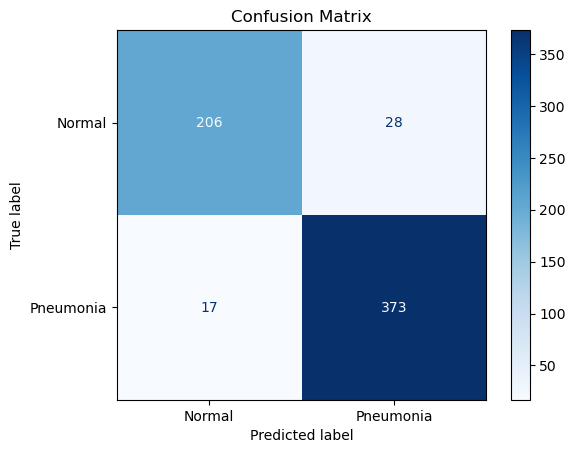

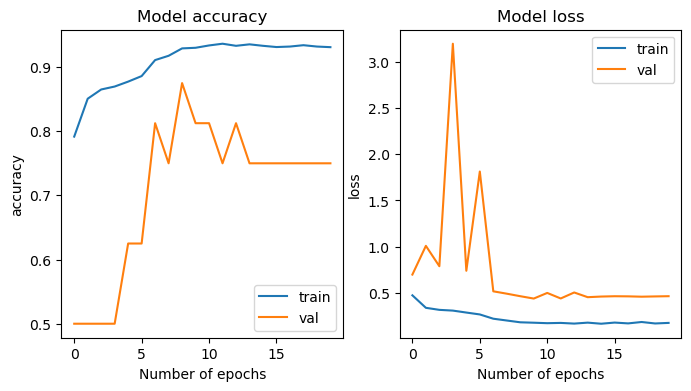

In [94]:
predictions = model.predict(test_data)
accuracy = accuracy_score(test_labels, np.round(predictions))*100
cm = confusion_matrix(test_labels, np.round(predictions))

cmd = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Pneumonia'])
cmd.plot(cmap = plt.cm.Blues)
plt.title('Confusion Matrix')

tn, fp, fn, tp = cm.ravel()
print('Test Metrics:')
precision = tp / (tp + fp) * 100
recall = tp / (tp + fn) * 100
print('Accuracy: {}%'.format(accuracy))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print(classification_report(test_labels, np.round(predictions), target_names = ['Normal (Class 0)','Pnuemonia (Class 1)']))

# Load the history
with open('model_history.pkl', 'rb') as f:
    history = pickle.load(f)
    
fig, ax = plt.subplots(1, 2, figsize = (8, 4))
ax = ax.ravel()

for i, metric in enumerate(['accuracy', 'loss']):
    ax[i].plot(history[metric])
    ax[i].plot(history['val_' + metric])
    ax[i].set_title('Model {}'.format(metric))
    ax[i].set_xlabel('Number of epochs')
    ax[i].set_ylabel(metric)
    ax[i].legend(['train', 'val'])

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
20/20 [==============================] - 36s 2s/step
Best KNN parameters: {'n_neighbors': 3, 'weights': 'uniform'}
Best Random Forest parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
KNN Accuracy: 0.7612179487179487
              precision    recall  f1-score   support

           0       0.77      0.52      0.62       234
           1       0.76      0.91      0.83       390

    accuracy                           0.76       624
   macro avg       0.76      0.71      0.72       624
weighted avg       0.76      0.76      0.75       624



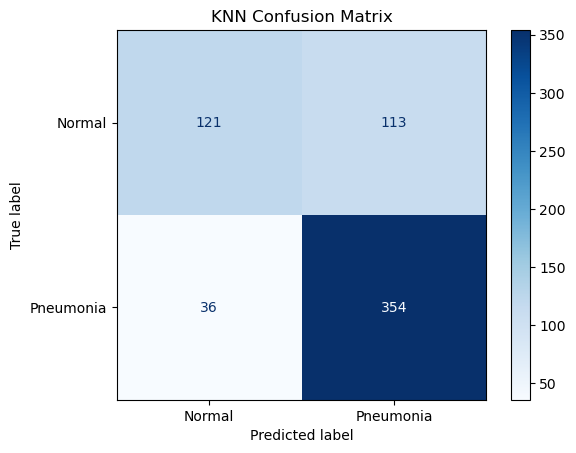

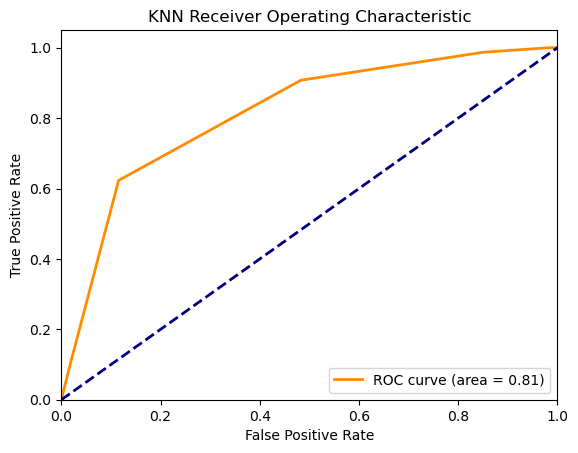

Random Forest with Adjusted Threshold Accuracy: 0.7772435897435898
              precision    recall  f1-score   support

           0       0.75      0.62      0.67       234
           1       0.79      0.87      0.83       390

    accuracy                           0.78       624
   macro avg       0.77      0.74      0.75       624
weighted avg       0.77      0.78      0.77       624



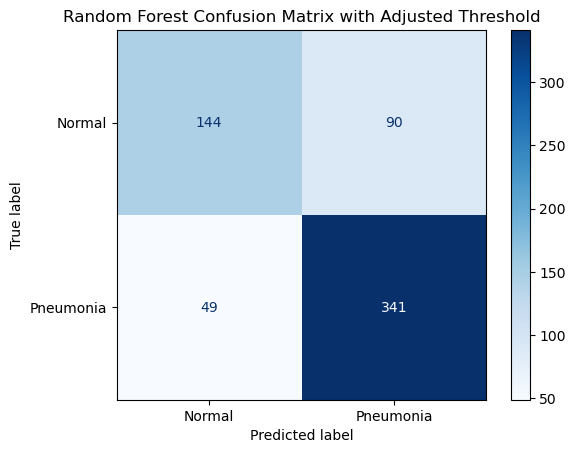

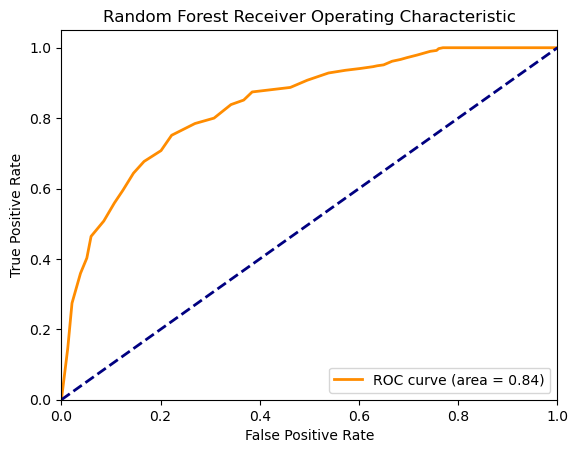

SVM with Adjusted Threshold Accuracy: 0.8397435897435898
              precision    recall  f1-score   support

           0       0.85      0.69      0.76       234
           1       0.83      0.93      0.88       390

    accuracy                           0.84       624
   macro avg       0.84      0.81      0.82       624
weighted avg       0.84      0.84      0.84       624



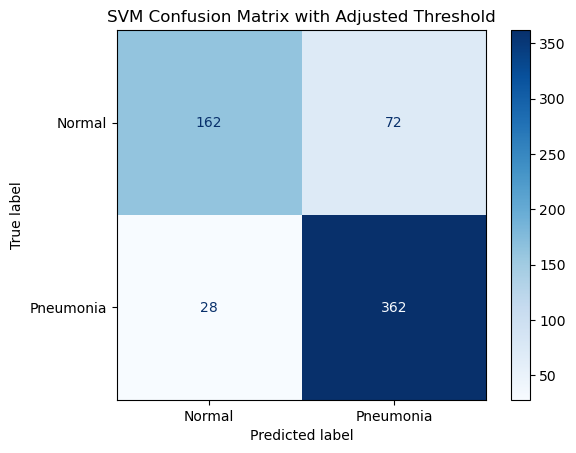

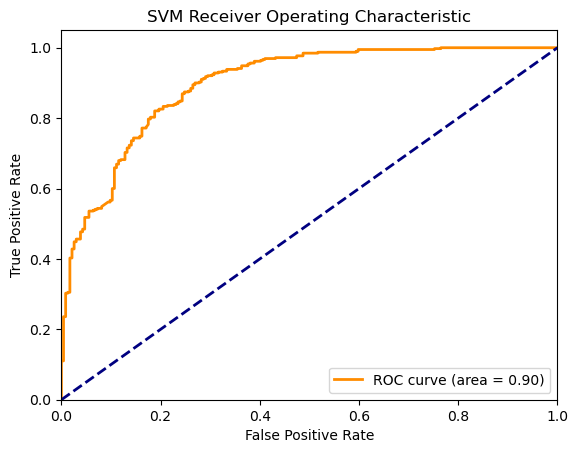

Ensemble with Adjusted Threshold Accuracy:  0.8141025641025641
              precision    recall  f1-score   support

           0       0.84      0.63      0.72       234
           1       0.81      0.93      0.86       390

    accuracy                           0.81       624
   macro avg       0.82      0.78      0.79       624
weighted avg       0.82      0.81      0.81       624



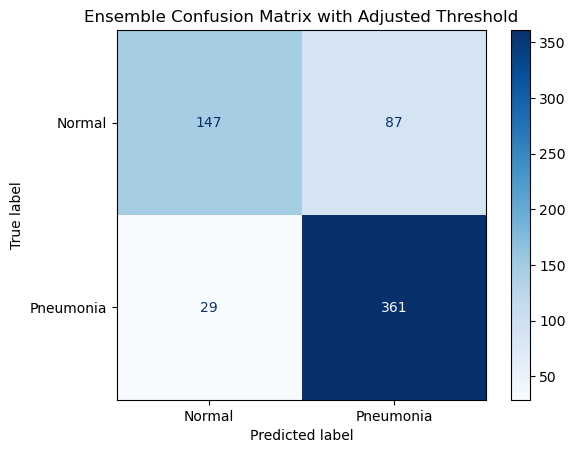

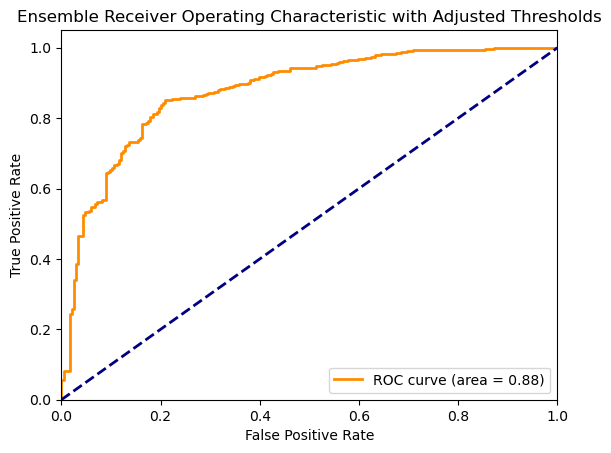

KNN Accuracy: 0.7612179487179487
Random Forest Accuracy: 0.7259615384615384
SVM Accuracy: 0.8157051282051282
Ensemble Accuracy: 0.8269230769230769


In [8]:

img_size = 150
batch_size = 32
train_set, val_set, test_data, test_labels = data_processing(img_size, batch_size)

# Load pre-trained VGG16 model 
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
model = Model(inputs=base_model.input, outputs=base_model.output)

def extract_features(model, data):
    features = model.predict(data)
    return features.reshape(len(features), -1)

# Extract features
train_features = extract_features(model, train_set[0][0])
val_features = extract_features(model, val_set[0][0])
test_features = extract_features(model, test_data)

# Flatten labels
train_labels = train_set[0][1]
val_labels = val_set[0][1]

# Standardize the features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

# Apply PCA
n_components = min(len(train_features), len(train_features[0]))  
pca = PCA(n_components=n_components)
train_features_pca = pca.fit_transform(train_features)
val_features_pca = pca.transform(val_features)
test_features_pca = pca.transform(test_features)


# Perform Grid Search for KNN parameters
param_grid = {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance']}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(train_features_pca, train_labels)

# Best parameters and KNN model
best_knn = grid_search.best_estimator_
print("Best KNN parameters:", grid_search.best_params_)


# Grid Search for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(train_features_pca, train_labels)

# Best Random Forest parameters and model
best_rf = grid_search_rf.best_estimator_
print("Best Random Forest parameters:", grid_search_rf.best_params_)

# Train individual models with best parameters
rf = best_rf
svm = SVC(probability=True, random_state=42)

# Fit the models
knn.fit(train_features_pca, train_labels)
rf.fit(train_features_pca, train_labels)
svm.fit(train_features_pca, train_labels)

# Ensemble the models using VotingClassifier
ensemble = VotingClassifier(estimators=[('knn', knn), ('rf', rf), ('svm', svm)], voting='soft')
ensemble.fit(train_features_pca, train_labels)

# Function to adjust the decision threshold
def adjust_threshold(model, test_features, test_labels):
    probabilities = model.predict_proba(test_features)[:, 1]
    precision, recall, thresholds = precision_recall_curve(test_labels, probabilities)
    f1_scores = 2 * recall * precision / (recall + precision)
    best_threshold = thresholds[np.argmax(f1_scores)]
    return best_threshold

# Adjust thresholds for Random Forest and SVM
rf_threshold = adjust_threshold(rf, test_features_pca, test_labels)
svm_threshold = adjust_threshold(svm, test_features_pca, test_labels)

def predict_with_threshold(model, features, threshold):
    probabilities = model.predict_proba(features)[:, 1]
    return (probabilities >= threshold).astype(int)

# Evaluate models with adjusted thresholds
def evaluate_model_with_threshold(model, threshold, test_features, test_labels, model_name):
    predictions = predict_with_threshold(model, test_features, threshold)
    print(f"{model_name} with Adjusted Threshold Accuracy: {accuracy_score(test_labels, predictions)}")
    print(classification_report(test_labels, predictions))
    ConfusionMatrixDisplay.from_predictions(test_labels, predictions, display_labels=['Normal', 'Pneumonia'], cmap=plt.cm.Blues)
    plt.title(f'{model_name} Confusion Matrix with Adjusted Threshold')
    plt.show()
    
    proba = model.predict_proba(test_features)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(test_features)
    fpr, tpr, _ = roc_curve(test_labels, proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Evaluate KNN 
def evaluate_knn(model, test_features, test_labels, model_name):
    predictions = model.predict(test_features)
    print(f"{model_name} Accuracy: {accuracy_score(test_labels, predictions)}")
    print(classification_report(test_labels, predictions))
    ConfusionMatrixDisplay.from_predictions(test_labels, predictions, display_labels=['Normal', 'Pneumonia'], cmap=plt.cm.Blues)
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()
    
    proba = model.predict_proba(test_features)[:, 1]
    fpr, tpr, _ = roc_curve(test_labels, proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Evaluate KNN
evaluate_knn(knn, test_features_pca, test_labels, "KNN")

# Evaluate Random Forest and SVM with adjusted thresholds
evaluate_model_with_threshold(rf, rf_threshold, test_features_pca, test_labels, "Random Forest")
evaluate_model_with_threshold(svm, svm_threshold, test_features_pca, test_labels, "SVM")

# Adjusting threshold for the ensemble
def ensemble_predict_with_threshold(ensemble, thresholds, test_features):
    knn_pred = knn.predict(test_features)
    rf_pred = predict_with_threshold(rf, test_features, thresholds[0])
    svm_pred = predict_with_threshold(svm, test_features, thresholds[1])
    final_pred = (knn_pred + rf_pred + svm_pred) >= 2
    return final_pred

ensemble_thresholds = [rf_threshold, svm_threshold]
ensemble_predictions = ensemble_predict_with_threshold(ensemble, ensemble_thresholds, test_features_pca)
print("Ensemble with Adjusted Threshold Accuracy: ", accuracy_score(test_labels, ensemble_predictions))
print(classification_report(test_labels, ensemble_predictions))
ConfusionMatrixDisplay.from_predictions(test_labels, ensemble_predictions, display_labels=['Normal', 'Pneumonia'], cmap=plt.cm.Blues)
plt.title('Ensemble Confusion Matrix with Adjusted Threshold')
plt.show()

# Evaluate Ensemble ROC AUC with Adjusted Thresholds
def evaluate_ensemble_with_threshold(ensemble, thresholds, test_features, test_labels):
    knn_proba = knn.predict_proba(test_features)[:, 1]
    rf_proba = rf.predict_proba(test_features)[:, 1]
    svm_proba = svm.predict_proba(test_features)[:, 1]
    ensemble_proba = (knn_proba + rf_proba * thresholds[0] + svm_proba * thresholds[1]) / 3

    fpr, tpr, _ = roc_curve(test_labels, ensemble_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Ensemble Receiver Operating Characteristic with Adjusted Thresholds')
    plt.legend(loc="lower right")
    plt.show()

# Evaluate Ensemble with Adjusted Thresholds
evaluate_ensemble_with_threshold(ensemble, ensemble_thresholds, test_features_pca, test_labels)

# Compare individual and ensemble performance
def compare_performance(models, test_features, test_labels):
    for model_name, model in models:
        predictions = model.predict(test_features)
        print(f"{model_name} Accuracy: {accuracy_score(test_labels, predictions)}")

models = [("KNN", knn), ("Random Forest", rf), ("SVM", svm), ("Ensemble", ensemble)]
compare_performance(models, test_features_pca, test_labels)